<a href="https://colab.research.google.com/github/project00/giftler/blob/master/inizio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [143]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout



In [142]:
# 1. Caricamento del dataset
df = pd.read_csv('train_data_cleaned.csv', sep = ';')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')
df = df.sort_values(['store_nbr', 'family', 'date'])

print("Store disponibili:", df['store_nbr'].unique())
print("Product Family disponibili:", df['family'].unique())



Store disponibili: [1 3]
Product Family disponibili: ['ACCESSORI' 'ACCESSORIES - FCA' 'BODY - FCA' 'CARROZZERIA'
 'CIRCULAR ECONOMY - FCA' 'ECONOMIA CIRCOLARE' 'EUROREPAR' 'FORWELT'
 'IAM AML' 'IAM CLC' 'IAM CLLP' 'LEISURE - FCA' 'LUBRICANTS - FCA'
 'MAINTENANCE - FCA' 'MANUTENZIONE' 'MECCANICA INCIDENT.' 'N.A.'
 'OTHER PRIVATE LABEL - FCA' 'PNEUMATICI DFS' 'PNEUMATICI EUROREPAR'
 'PPP.ATTREZI' 'REPAIR - FCA' 'TIRES - FCA' 'USURA' 'WEAR & TEAR - FCA'
 'WORKSHOP PRODUCTS - FCA']


In [144]:
Storedisponibili : ['1','3']

ProductFamilydisponibili: [
    'IAM CLLP',
    'N.A.',
    'BODY - FCA',
    'IAM CLC',
    'REPAIR - FCA',
    'IAM AML',
    'WEAR & TEAR - FCA',
    'MAINTENANCE - FCA',
    'CARROZZERIA',
    'MECCANICA INCIDENT.',
    'ACCESSORI',
    'MANUTENZIONE',
    'USURA',
    'PPP.ATTREZI',
    'EUROREPAR',
    'CIRCULAR ECONOMY - FCA',
    'ECONOMIA CIRCOLARE',
    'ACCESSORIES - FCA',
    'WORKSHOP PRODUCTS - FCA',
    'PNEUMATICI DFS',
    'OTHER PRIVATE LABEL - FCA',
    'PNEUMATICI EUROREPAR',
    'TIRES - FCA',
    'FORWELT',
    'LEISURE - FCA',
    'LUBRICANTS - FCA'
]

In [145]:
# 2. Filtrare per Store e Product Family specifici
store_selected = 1  # Aggiorna con il tuo valore
family_selected = 'CARROZZERIA'  # Aggiorna con il tuo valore

df = df[(df['store_nbr'] == store_selected) & (df['family'] == family_selected)].reset_index(drop=True)

In [135]:
df.head()

,date,store_nbr,family,sales,city,cluster,dcoilwtico
0,2023-08-07,1,MANUTENZIONE,144.2320,PZ,123.911224,262.24
1,2023-08-07,1,MANUTENZIONE,181.1452,PZ,192.480757,428.30
2,2023-08-07,1,MANUTENZIONE,78.6828,PZ,78.734522,170.00
3,2023-08-07,1,MANUTENZIONE,181.1452,BN,192.480757,428.30
4,2023-08-07,1,MANUTENZIONE,36.7495,BN,34.352471,79.40


In [147]:
#3. Estrazione delle feature temporali
df['day_of_week'] = df[ 'date'].dt.dayofweek
df ['month'] = df[ 'date'].dt.month

# 4. Normalizzazione delle variabili numeriche con scaler separati
scaler_sales = MinMaxScaler()
# Converte esplicitamente la colonna 'sales' a valori numerici
df['dcoilwtico'] = pd.to_numeric(df['dcoilwtico'], errors='coerce')
# Controlla e gestisce eventuali valori NaN che possono essere stati introdotti dal cast
df = df.dropna(subset=['dcoilwtico'])
df['sales_scaled'] = scaler_sales.fit_transform(df[['dcoilwtico']])

scaler_onpromotion = MinMaxScaler( )
# Converte esplicitamente la colonna 'sales' a valori numerici
df['sales'] = pd.to_numeric(df['sales'], errors='coerce')
# Controlla e gestisce eventuali valori NaN che possono essere stati introdotti dal cast
df = df.dropna(subset=['sales'])
# Effettua il ridimensionamento della colonna 'sales'
df['onpromotion_scaled'] = scaler_onpromotion.fit_transform(df[['sales']])
print(df.isnull().sum())


# 5. Definire le feature
numerical_features =['sales_scaled','onpromotion_scaled', 'day_of_week','month']
seq_length = 14 # finestre temporali di 14 giorni

# 6. Creazione delle sequenze
X_num, y = [], []
num_data = df [numerical_features].values

for i in range(len(df) - seq_length):
  X_num. append (num_data[i:i+seq_length])
  y.append (num_data[i+seq_length, 0]) # Target: 'sales _scaled' al tempo t+seq_length

# Convertire in array numpy
X_num = np.array(X_num)
y = np.array(y)
# 7. Separare gli ultimi 14 giorni come future test set
# Nota: Dobbiamo assicurare che ci siano abbastanza dati per creare le sequenze

future_seq_length = 200
X_num_future = X_num[-future_seq_length: ]
y_future = y[-future_seq_length:]

# Rimuovere gli ultimi 14 giorni dal dataset
X_num = X_num[:-future_seq_length]
y = y[:-future_seq_length]

#8. Suddivisione train-test
split_ratio = 0.5
split_index = int(len(X_num) * split_ratio)
X_num_train, X_num_test = X_num[:split_index], X_num[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

date                     0
store_nbr                0
family                   0
sales                    0
city                  3719
cluster                  0
dcoilwtico               0
day_of_week              0
month                    0
sales_scaled             0
onpromotion_scaled       0
dtype: int64


Epoch 1/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 35397.7539 - mae: 113.5911 - val_loss: 52890.3555 - val_mae: 114.6596
Epoch 2/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 30548.9824 - mae: 108.7882 - val_loss: 51892.7500 - val_mae: 119.3379
Epoch 3/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 31491.7891 - mae: 109.8608 - val_loss: 52530.4180 - val_mae: 115.7059
Epoch 4/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 30881.2598 - mae: 109.2560 - val_loss: 51918.4609 - val_mae: 118.8567
Epoch 5/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 31782.9023 - mae: 111.7136 - val_loss: 51793.3086 - val_mae: 120.1104
Epoch 6/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 28912.8008 - mae: 106.7592 - val_loss: 51584.4102 - val_mae: 123.3742
Epoch 7/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 28607.9023 - mae: 107.9725 - val_loss: 51590.1680 - val_mae: 128.1389
Epoch 8/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 29627.6133 -

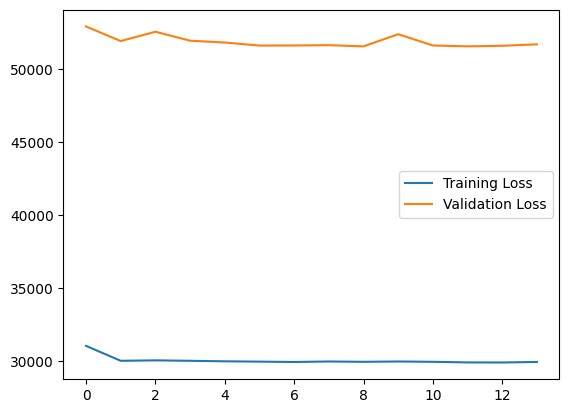

In [156]:
#9. Costruzione del modello LSTM
input_num = Input (shape=(seq_length, X_num.shape[2]), name= 'input_num')
x = LSTM(64, activation='relu') (input_num)
x = Dense(64, activation='relu')(x)
x = Dropout (0.2) (x)
output = Dense (1) (x)

model = Model (inputs=input_num, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 10. Addestramento del modello
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_num_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


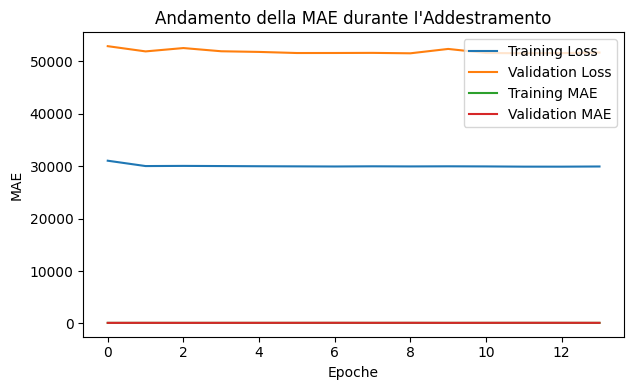

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 26585
'y' sizes: 9922


In [157]:
from sklearn.metrics import mean_absolute_error
#11. Plot delle metriche di addestramento
plt.figure(figsize=(12, 4))

# Plot della loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label= 'Validation Loss')
plt. title('Andamento della Loss durante I\'Addestramento' )
plt.xlabel( 'Epoche' )
plt.ylabel('Loss')
plt. legend()

# Plot del MAE
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label= 'Validation MAE')
plt. title('Andamento della MAE durante I\'Addestramento' )
plt.xlabel( 'Epoche' )
plt.ylabel('MAE')
plt. legend()

plt.tight_layout ()
plt.show()

# 12. Valutazione del modello sul test set standard
test_loss, test_mae = model.evaluate(
  X_num_test,
  y_test
)

print(f"Test MAE: (test_mae)")

# 13. Previsioni sul test set standard
predictions_test = model.predict(X_num_test)

# 14. Inverse scaling delle previsioni e dei valori reali per il test set standard
y_test_inversed = scaler_sales.inverse_transform(y_test.reshape(-1, 1)).flatten()
predictions_test_inversed = scaler_sales.inverse_transform(predictions_test).flatten()
realt_test_mae = mean_absolute_error(y_test_inversed, predictions_test_inversed)
print(f"Real Test MAE (Ultimi 14 giorni): {realt_test_mae}")

# 15. Previsioni sul future test set (ultimi 14 giorni)
predictions_future = model.predict(X_num_future)

# Inverse scaling delle previsioni e dei valori reali per il future test set
y_future_inversed = scaler_sales.inverse_transform(y_future.reshape(-1, 1)).flatten()
predictions_future_inversed = scaler_sales.inverse_transform(predictions_future).flatten()

# 16. Plot delle previsioni vs valori reali sul future test set
plt.figure(figsize=(12, 6))
plt.plot(y_future_inversed, label='Valori Reali (Ultimi 14 giorni)')

plt.plot(predictions_future_inversed, label='Previsioni del Modello (Ultimi 14 giorni)')
plt.title('Confronto tra Previsioni e Valori Reali sugli Ultimi 14 Giorni' )
plt.xlabel('Giorni' )
plt.ylabel( 'Vendite' )
plt.legend()
plt.show()

# 17. Calcolo del MAE sul future test set
from sklearn.metrics import mean_absolute_error
future_mae = mean_absolute_error(y_future_inversed, predictions_future_inversed)
print(f"Future Test MAE (Ultimi 14 giorni): {future_mae}")

XGBOOST MODEL

date              0
store_nbr         0
family            0
sales             0
city          19185
cluster           0
dcoilwtico        0
dtype: int64
[0]	train-mae:126.79073	eval-mae:145.37167
[50]	train-mae:17.89521	eval-mae:22.63294
[100]	train-mae:16.13502	eval-mae:22.37416
[150]	train-mae:14.75342	eval-mae:21.62042
[200]	train-mae:13.68779	eval-mae:21.49019
[250]	train-mae:12.79389	eval-mae:21.84706
[253]	train-mae:12.71548	eval-mae:21.83131
Test MAE: 21.792068371442323
Future Test MAE (Ultimi 14 giorni): 19.206979164014538
MAE Normalizzato: 10.34%


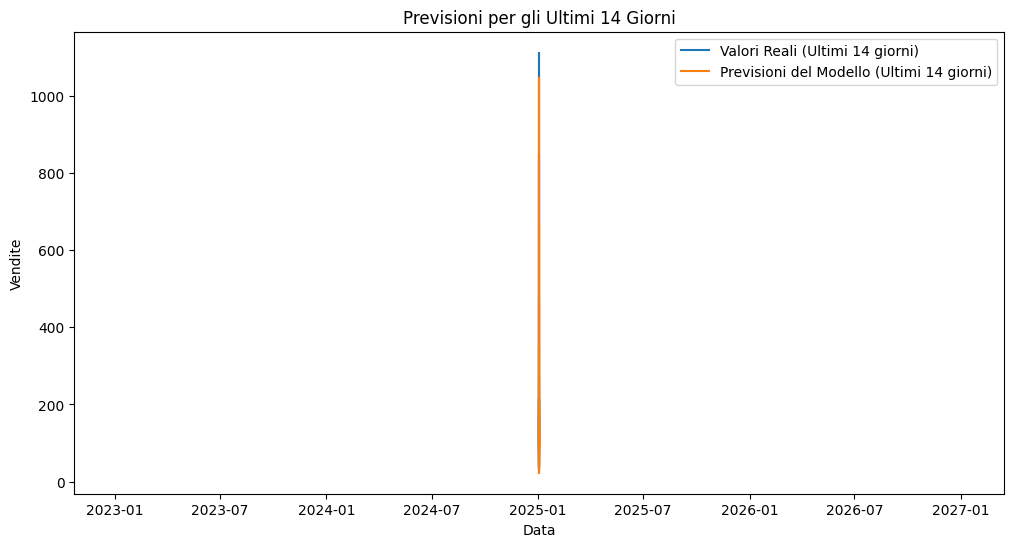

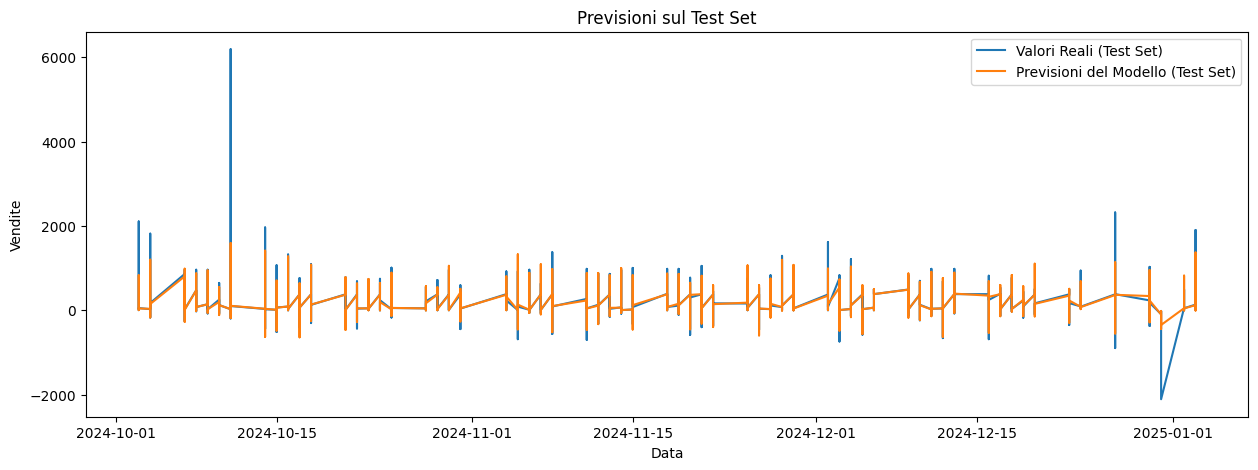

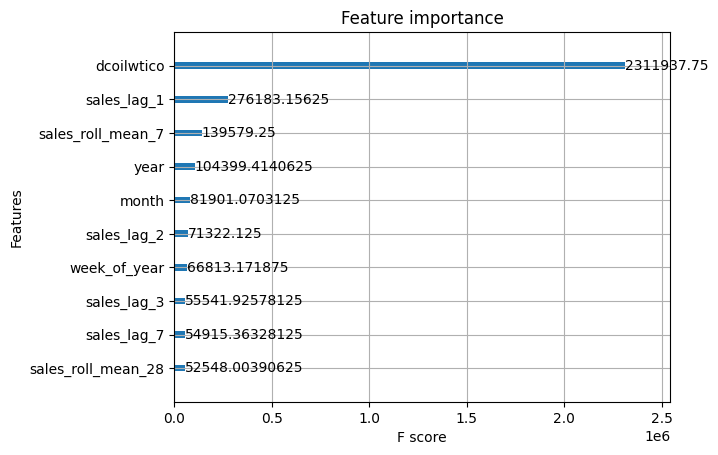

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
# 1. Caricamento del dataset
df = pd.read_csv('train_data_cleaned.csv', sep = ';')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')
df = df.sort_values([ 'store_nbr','family', 'date'])

# 2. Filtrare per Store e Product Family specifici
store_selected = 1 # Aggiorna con il tuo valore
family_selected = 'CARROZZERIA' # Aggiorna con il tuo valore

# Converte esplicitamente la colonna 'sales' a valori numerici
df['sales'] = pd.to_numeric(df['sales'], errors='coerce')
# Controlla e gestisce eventuali valori NaN che possono essere stati introdotti dal cast
df = df.dropna(subset=['sales'])



# Converte esplicitamente la colonna 'sales' a valori numerici
df['dcoilwtico'] = pd.to_numeric(df['dcoilwtico'], errors='coerce')
# Controlla e gestisce eventuali valori NaN che possono essere stati introdotti dal cast
df = df.dropna(subset=['dcoilwtico'])


print(df.isnull().sum())



df = df[(df['store_nbr'] == store_selected) & (df['family'] == family_selected)].reset_index(drop=True)
# 3. Estrazione delle feature temporali
df['day_of_week'] = df['date'] .dt.dayofweek
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
df[ 'month'] = df['date'].dt.month
df[ 'year'] = df['date'].dt.year

#4.Creazione delle feature lag
lag_features = [1, 2, 3, 7, 14, 21, 28]
for lag in lag_features:
  df[f'sales_lag_{lag}'] = df['sales'].shift(lag)

# 5. Creazione delle medie mobili
window_sizes = [7, 14, 28]
for window in window_sizes:
  df[f'sales_roll_mean_{window}'] = df['sales'].shift(1).rolling(window=window).mean()
# 6. Gestione dei valori mancanti
df = df.dropna()
#7. Ordinamento del dati per data
df = df.sort_values('date').reset_index(drop=True)
# 8. Separazione degli ultimi 14 giorni come future test set
future_test_df = df.tail(28).copy()

# Rimuovere gli ultimi 14 giorni dal dataset principale
df = df.iloc[:-28]
# 9. Selezione delle feature e target
features = [
'dcoilwtico',
'day_of_week',
'week_of_year',
'month',
'year'
]
# Aggiungere le feature lag e le medie mobili
features += [f'sales_lag_{lag}' for lag in lag_features]
features += [f'sales_roll_mean_{window}' for window in window_sizes]

target = 'sales'

# 10. Suddivisione train-test sul dataset rimanente
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

#11. Creazione del DMatrix per XBoost
train_matrix = xgb.DMatrix(X_train, label=y_train)
test_matrix = xgb.DMatrix(X_test, label=y_test)

# 12. Impostazione dei parametri di XBoost
params = {
'objective': 'reg:squarederror', # Remove the whitespace before 'squarederror'
'eval_metric': 'mae',  # Replace the whitespace with an underscore
'learning_rate': 0.1,
'max_depth': 6,
'colsample_bytree': 0.8,
'subsample': 0.8,
'seed': 42
}

# 13. Addestramento del modello
evals = [(train_matrix, 'train'), (test_matrix,'eval')]
model = xgb.train(params, train_matrix, num_boost_round=1000, evals=evals, early_stopping_rounds=50, verbose_eval=50)

# 14. Previsioni sul test set
y_pred_test = model.predict(test_matrix)

# 15. Valutazione del modello sul test set
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f"Test MAE: {mae_test}")
# 16. Previsioni sul future test set (ultimi14 giorni)
X_future = future_test_df[features]
y_future = future_test_df[target]

future_matrix = xgb.DMatrix(X_future)

y_pred_future = model.predict(future_matrix)
# 17. Valutazione del modello sul future test set
mae_future = mean_absolute_error(y_future, y_pred_future)
mae = mean_absolute_error(y_future, y_pred_future)

# Calcola la media dei valori reali
mean_y_true = np.mean(y_future)
# Calcola il MAE normalizzato in percentuale
mae_normalizzato = (mae / mean_y_true) * 100

print(f"Future Test MAE (Ultimi 14 giorni): {mae_future}")
print(f"MAE Normalizzato: {mae_normalizzato:.2f}%")

# 18. Plot delle previsioni vs valori reali sul future test set
plt. figure(figsize=(12, 6))
plt.plot(future_test_df['date'], y_future.values, label='Valori Reali (Ultimi 14 giorni)')
plt.plot(future_test_df['date'], y_pred_future, label='Previsioni del Modello (Ultimi 14 giorni)')
plt.title('Previsioni per gli Ultimi 14 Giorni')
plt.xlabel( 'Data')
plt.ylabel( 'Vendite')
plt. legend()
plt. show()
# 19. Plot delle previsioni vs valori reali sul test set
plt.figure(figsize=(15, 5))
plt.plot(test_df['date'], y_test.values, label='Valori Reali (Test Set)')
plt.plot(test_df['date'], y_pred_test, label='Previsioni del Modello (Test Set)')
plt. title('Previsioni sul Test Set')
plt.xlabel( 'Data' )
plt.ylabel('Vendite' )
plt. legend ()
plt. show ( )
# 20.Importanza delle feature
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt. show()